In [2]:
import random
import time

# Imports

import pickle

import pandas as pd
import numpy as np
import random
import seaborn as sns
import sklearn.cluster as cluster
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

sns.set()

In [3]:
# Importing gym and its other stuff
import gym
from gym import logger as gymlogger
gymlogger.set_level(40) # err only

env = gym.make("CartPole-v1")

In [4]:
### LOGGING OBJECT

class Logger:
    def __init__(self, filename='./data.csv'):
        self.filename = filename

    def __parseStats(self, stats) -> str:
        print(stats)
        obsv = stats[0]
        reward = stats[1]
        done = stats[2]
        info = stats[3]

        obsvCSV = ','.join([x.astype(str) for x in obsv])
        return f"{obsvCSV},{reward},{done},{info}"

    def log(self, stats, action, totalReward) -> None:
        # open file
        self.__parseStats(stats=stats)
        with open(self.filename, 'a') as file:
            file.write(f"{self.__parseStats(stats=stats)},{totalReward},{action}\n")
            pass


In [5]:
### Agent OBJECT

class Agent:
    def __init__(self, environment, logger:Logger) -> None:
        self.env = environment
        self.logger = logger
        self.isRunning = True
        self.curReward = 0

    def __reset(self):
        startState = self.env.reset()
        self.isRunning = True
        self.curReward = 0
        return startState

    def policy(self) -> int:
        return random.randint(0,1)

    def run(self) -> None:
        self.__reset()
        while self.isRunning:
            action = self.policy() # determining action
            stats = self.env.step(action) # execute action

            # update state
            self.isRunning = stats[2]==False
            self.curReward += stats[1] if self.isRunning else 0

            # log information etc
            self.logger.log(stats=stats, action=action, totalReward=self.curReward)

In [6]:
for _ in range(1000):
    agt = Agent(gym.make("CartPole-v1"), Logger())
    agt.run()

(array([-0.01929649, -0.23070222, -0.0255028 ,  0.28114668], dtype=float32), 1.0, False, False, {})
(array([-0.01929649, -0.23070222, -0.0255028 ,  0.28114668], dtype=float32), 1.0, False, False, {})
(array([-0.02391053, -0.03522594, -0.01987987, -0.01946939], dtype=float32), 1.0, False, False, {})
(array([-0.02391053, -0.03522594, -0.01987987, -0.01946939], dtype=float32), 1.0, False, False, {})
(array([-0.02461505, -0.23005724, -0.02026926,  0.2668755 ], dtype=float32), 1.0, False, False, {})
(array([-0.02461505, -0.23005724, -0.02026926,  0.2668755 ], dtype=float32), 1.0, False, False, {})
(array([-0.0292162 , -0.42488414, -0.01493175,  0.55309707], dtype=float32), 1.0, False, False, {})
(array([-0.0292162 , -0.42488414, -0.01493175,  0.55309707], dtype=float32), 1.0, False, False, {})
(array([-0.03771388, -0.22955571, -0.00386981,  0.25574732], dtype=float32), 1.0, False, False, {})
(array([-0.03771388, -0.22955571, -0.00386981,  0.25574732], dtype=float32), 1.0, False, False, {})


# Analysing data

Q-learning requires discrete states from the environment, however, the Cartpole problem provides states that are continuous.


We can approach this by creating discrete steps in the environment. While this can be done through trial & error by making intuitive guesses on the different states, a more calculative approach will be to use machine learning to create clusters ("buckets") to be used as our steps.

In [7]:
### Importing data

rawData = pd.read_csv('./data.csv')
rawData

cartPos   cartVel   poleAngle   poleVel   reward   done  \
0      0.024236  0.191275    0.003320 -0.287982      1.0  False   
1      0.028062 -0.003895   -0.002439  0.005746      1.0  False   
2      0.027984  0.191262   -0.002324 -0.287706      1.0  False   
3      0.031809 -0.003826   -0.008079  0.004243      1.0  False   
4      0.031733  0.191410   -0.007994 -0.290978      1.0  False   
...         ...       ...         ...       ...      ...    ...   
51938  0.092686  0.385772   -0.163270 -0.740690      1.0  False   
51939  0.100402  0.193236   -0.178084 -0.503515      1.0  False   
51940  0.104266  0.390361   -0.188154 -0.846607      1.0  False   
51941  0.112074  0.198236   -0.205086 -0.618496      1.0  False   
51942  0.116038  0.395542   -0.217456 -0.968128      1.0   True   

       idkwhatthisis  totalReward  action  
0              False          1.0       1  
1              False          2.0       0  
2              False          3.0       1  
3              False          4.0       0  
4              False          5.0       1  
...              ...          ...     ...  
51938          False         24.0       0  
51939          False         25.0       0  
51940          False         26.0       1  
51941          False         27.0       0  
51942          False         27.0       1  

[51943 rows x 9 columns]

## Clustering Approach

There are a handful of methods we can use to cluster our data for prediction.
* Affinity propagation
* Mean-shift
* K-means (not optimal as we have to determine the number of 'buckets')

In [8]:
obsvData = rawData[['cartPos', 'cartVel', ' poleAngle', ' poleVel']]
obsvData

cartPos   cartVel   poleAngle   poleVel
0      0.024236  0.191275    0.003320 -0.287982
1      0.028062 -0.003895   -0.002439  0.005746
2      0.027984  0.191262   -0.002324 -0.287706
3      0.031809 -0.003826   -0.008079  0.004243
4      0.031733  0.191410   -0.007994 -0.290978
...         ...       ...         ...       ...
51938  0.092686  0.385772   -0.163270 -0.740690
51939  0.100402  0.193236   -0.178084 -0.503515
51940  0.104266  0.390361   -0.188154 -0.846607
51941  0.112074  0.198236   -0.205086 -0.618496
51942  0.116038  0.395542   -0.217456 -0.968128

[51943 rows x 4 columns]

### EDA

We first begin by doing surface level data analysis.

As we observe the plot below, we can observe that certain attributes have much stronger relations than others.

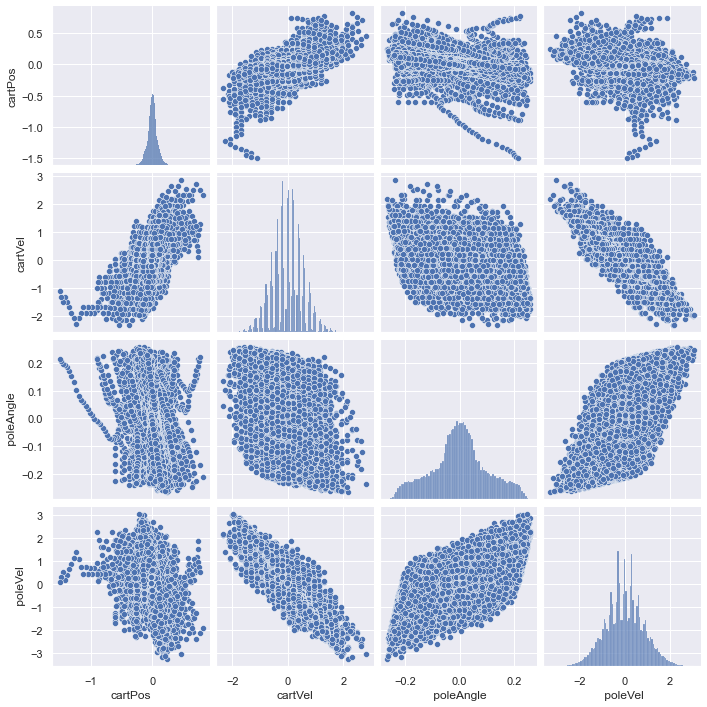

In [9]:
sns.pairplot(obsvData)

### Splitting data into test and training data

In order train then test our models, we split the data with a 60/40 split for our train/test data respectively.

In [10]:
dataTrain, dataTest = train_test_split(obsvData, test_size=0.4)

dataTrain

cartPos   cartVel   poleAngle   poleVel
17084 -0.087058 -0.363705    0.060572  0.491631
51552 -0.056575 -0.430927    0.031200  0.489957
38852 -0.052031  0.139356    0.109382  0.110704
46954 -0.063360 -0.790347    0.088876  1.262192
10113  0.014291  0.810775   -0.067736 -1.264314
...         ...       ...         ...       ...
44172 -0.140080 -0.026339    0.055176 -0.013932
27579 -0.106857 -1.324259    0.143312  1.937314
8314   0.036074  0.044947    0.016905 -0.007539
13451 -0.139468 -0.764873    0.238039  1.508395
21574  0.068872 -0.566479    0.016070  0.824859

[31165 rows x 4 columns]

The function below iterates over a range and calculates the Mean Squared Error for different k-mean models, from 2 buckets to 24 buckets. The resultant data is then graphed.

{2: 0.41918196936292157, 3: 0.2349174053738929, 4: 0.15813111747544983, 5: 0.12036590548278935, 6: 0.09604794178442097, 7: 0.0821274391984217, 8: 0.07291416891782705, 9: 0.06532060046125783, 10: 0.06013415793579493, 11: 0.05509780237354002, 12: 0.0523518363427325, 13: 0.04889382294531024, 14: 0.04632292305372924, 15: 0.043902589317991396, 16: 0.04172213673001324, 17: 0.039608210492665726, 18: 0.03784837445039764, 19: 0.03670888485449298, 20: 0.03516403217585859, 21: 0.033905824370391954, 22: 0.03293085529975444, 23: 0.03185629721118458, 24: 0.030684497111809393}


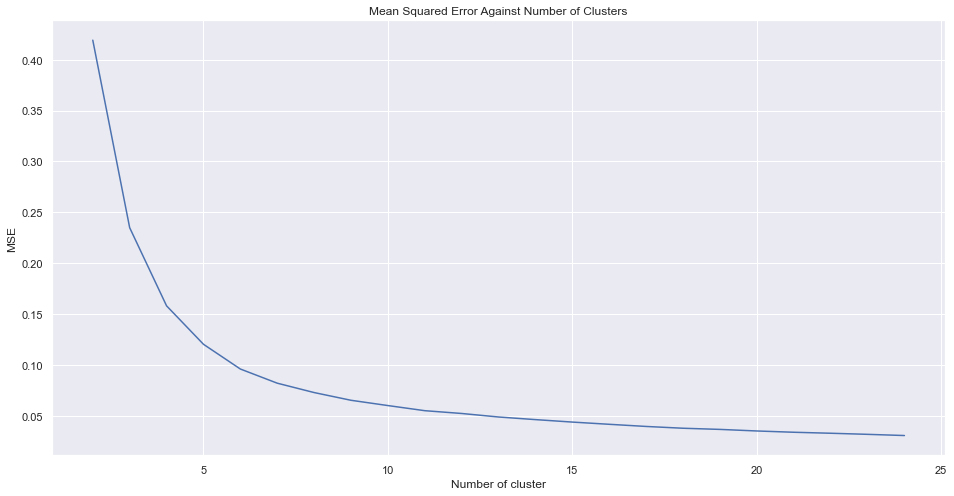

In [19]:
def testKMean():
    mse = {}
    for i in range(2, 25):
        model = cluster.KMeans(init="k-means++",n_clusters=i).fit(dataTrain)
        mse[i] = model.inertia_/dataTrain.shape[0]

        # exporting models
        with open(f"./models/klearn_{i}.pkl", "wb") as modelFile:
            pickle.dump(model, modelFile)

    print(mse)
    plt.figure(figsize=(16,8))
    plt.title("Mean Squared Error Against Number of Clusters")
    plt.plot(list(mse.keys()), list(mse.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("MSE")





testKMean()

### Observations

From the graph above, we notice a steep decline in the MSE as the number of buckets increase from 2 to ~10. Following which, we can further observe that the $MSE\rightarrow0.03$.

This data informs us that the models with ~10 or more buckets have better classification of data. However, to determine the optimal number of buckets to use for our agent, iterative testing needs to be done.


In [20]:
### testing importing model
modelLoad = open('./models/klearn_8.pkl', 'rb')
thisModel = pickle.load(modelLoad)
modelLoad.close()

thisModel.score(dataTest)

-1531.439747507843